In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ssmdm.models import Accumulator2D, DDM
from ssmdm.misc import generate_clicks, factor_analysis

# preprocessing
from ssm.preprocessing import factor_analysis_with_imputation
from tqdm.auto import trange

# for initialization
from ssm.optimizers import adam_step, rmsprop_step, sgd_step, convex_combination
from autograd.scipy.misc import logsumexp
from autograd.tracer import getval
from autograd.misc import flatten
from autograd import value_and_grad

**Create model and generate data**

In [176]:
from ssm.core import BaseHMM
from ssm.transitions import RecurrentOnlyTransitions
from ssm.init_state_distns import InitialStateDistribution
from ssmdm.models import Accumulator2DObservations

class Accumulator2DTransitions(RecurrentOnlyTransitions):
    def __init__(self, K, D, M=0, scale=100):
        assert K == 3
        assert D == 2
        assert M == 2
        super(Accumulator2DTransitions, self).__init__(K, D, M)
        
        self.Ws = np.zeros((K,M))
        self.Rs = np.array([[scale, 0], [0, 0], [0, scale]]).reshape((K,D)) # K by D
#         self.Rs = np.array([[scale, -scale], [0, 0], [-scale, scale]]).reshape((K,D)) # K by D
        self.r = np.array([-scale, 0, -scale])
        
    @property
    def params(self):
        return ()
    
    @params.setter
    def params(self, value):
        pass
    
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass
    
    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        pass
    
def Accumulator2D(D=2, M=2, betas=np.ones(2,), sigmas=1e-3 * np.ones((3, 2)), a_diag=np.ones((3,2,1))):
    K, D, M = 3, 2, 2
    
    # Build the initial state distribution, the transitions, and the observations
    init_state_distn = InitialStateDistribution(K, D, M)
    init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
    transition_distn = Accumulator2DTransitions(K, D, M)
    observation_distn = Accumulator2DObservations(K, D, M, betas=betas, sigmas=sigmas, a_diag=a_diag)
    
    return BaseHMM(K, D, M, init_state_distn, transition_distn, observation_distn)

In [177]:
# create 2D accumulator

# sigmas = np.array([[2e-4,1e-4],[3e-4,3e-4],[1e-4,2e-4]])
sigmas = np.array([[1e-4,1e-4],[5e-4,5e-4],[1e-4,1e-4]])
betas = np.array([1.0,1.0])
a_diag = np.ones((3,2,1))
acc2 = Accumulator2D(sigmas=sigmas,betas=betas,a_diag=a_diag)

# Sample state trajectories
T = 100 # number of time bins
trial_time = 1.0 # trial length in seconds
dt = 0.01 # bin size in seconds
N_samples = 100 

# input statistics
total_rate = 40 # the sum of the right and left poisson process rates is 40

us = []
zs = []
xs = []

for smpl in range(N_samples):

    # randomly draw right and left rates
    rate_r = np.random.randint(0,total_rate+1)
    rate_l = total_rate - rate_r

    # generate binned right and left clicks
    u_r, u_l = generate_clicks(T=trial_time,dt=dt,rate_r=rate_r,rate_l=rate_l)
    
    # input is sum of u_r and u_l
    u = 0.1*np.array([u_r,u_l]).T
    z, x = acc2.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

In [178]:
# generate data
N = 10
D = 2
C = np.random.randn(N, D)
ys = [np.dot(x, C.T) +1.0 + .1 * np.random.randn(T, N) for x in xs]

**Preprocess with factor analysis**

In [179]:
# run factor analysis
fa, xhats, Cov_xhats, lls = factor_analysis_with_imputation(D, ys, masks=None, num_iters=50)
# Cfa, my_xhats, my_lls, psi = factor_analysis(D, ys, num_iters=50) # my FA code

/Users/davidzoltowski/github/pybasicbayes/pybasicbayes/util/stats.py:184: RuntimeWarning: divide by zero encountered in true_divide
  return 1./np.random.gamma(alpha, 1./beta)


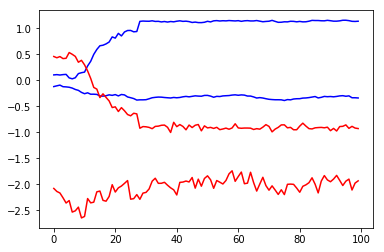

In [180]:
tr = 0
# tr += 1
plt.figure()
plt.plot(xs[tr],color='b')
plt.plot(xhats[tr],'r')

**Optimize affine transformation of output latents x from factor analysis**

$$ 
\hat{R}, \hat{r} = \mathrm{argmax}_{R, r} \log p( \, R \hat{x} + r \, | \, \theta_\text{AR-HMM})
$$
where $\hat{x}$ are the expected values of the latents output from factor analysis and $\theta_\text{AR-HMM}$ are the prior parameters of the model of interest.

In [181]:
# initialize 
R = 0.5*np.random.randn(2,2)
r = 0.0*np.random.randn(2)
params = [R,r]
# params = [R]
T = sum([x.shape[0] for x in xhats])

In [182]:
# define objective
# sigmas = np.array([[1e-4,1e-4],[5e-4,5e-4],[1e-4,1e-4]])

def objective(params, itr):
    T = sum([x.shape[0] for x in xhats])
    new_datas = [np.dot(x,params[0].T)+params[1] for x in xhats]
#     new_datas = [np.dot(x,params[0].T) for x in xhats]
    obj = Accumulator2D(sigmas = np.array([[1e-5,1e-5],[1e-3,1e-3],[1e-5,1e-5]])).log_likelihood(new_datas,inputs=us)
    return -obj / T

In [183]:
# optimize marginal likelihood of p(Rx+r|theta_arhmm), with respect to R, r

num_iters = 50
state = None
lls = [-objective(params, 0) * T]
pbar = trange(num_iters)
pbar.set_description("Epoch {} Itr {} LP: {:.1f}".format(0, 0, lls[-1]))

for itr in pbar:
    params, val, g, state = sgd_step(value_and_grad(objective), params, itr, state)
    lls.append(-val * T)
    pbar.set_description("LP: {:.1f}".format(lls[-1]))
    pbar.update(1)

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [184]:
R = params[0]
r = params[1]
# r = 0.0
print("R = ", R)
print("r = ", r)

R =  [[ 0.05472646  0.17511818]
 [-0.2556941   0.05088802]]
r =  [0.3153035  0.26639082]


Text(0,0.5,'x')

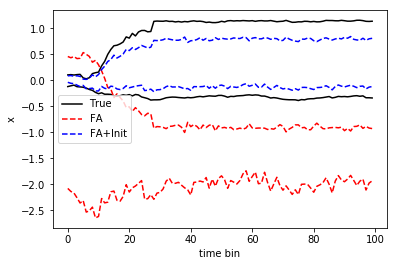

In [189]:
tr = 0
# tr += 1
plt.figure()
lab1,_ = plt.plot(xs[tr],color='k')
lab2,_ = plt.plot(xhats[tr],'r--')
lab3,_ = plt.plot(xhats[tr].dot(R.T)+r,'b--')
plt.legend([lab1,lab2,lab3],['True','FA','FA+Init'])
plt.xlabel('time bin')
plt.ylabel('x')
# plt.savefig('example_trial.png')

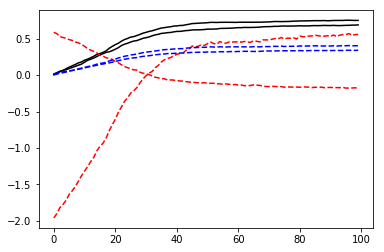

In [186]:
x_mean = np.mean(xs, axis=0)
xhat_mean = np.mean(xhats, axis=0)
x_trans = [np.dot(x,R.T)+r for x in xhats]
xtrans_mean = np.mean(x_trans, axis=0)

plt.figure()
plt.plot(x_mean,color='k')
plt.plot(xhat_mean,'r--')
plt.plot(xtrans_mean,'b--')

In [187]:
x_transformed1 = [ (np.dot(x,R.T)+r)[:,0] for x in xhats]
x_transformed2 = [ (np.dot(x,R.T)+r)[:,1] for x in xhats]
print(np.max(x_transformed1))
print(np.max(x_transformed2))

max_x1 = np.max(x_transformed1)
max_x2 = np.max(x_transformed2)

R_new = (R.T*np.array([1.25 / max_x1,1.25 / max_x2])).T
r_new = r * np.array([1.25 / max_x1,1.25 / max_x2])

0.6847155076672364
0.5512012373633193


In [188]:
R = (R.T*np.array([1.1 / max_x1,1.1 / max_x2])).T
r = r * np.array([1.1 / max_x1,1.1 / max_x2])

In [165]:
print(np.max(x_transformed1))
print(np.max(x_transformed2))

1.1
1.0999999999999999


In [ ]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(C,aspect='auto')
plt.title('True C')
plt.clim([-2.5,2.5])
plt.subplot(1,3,2)
plt.imshow(fa.W,aspect='auto')
plt.title('FA')
plt.clim([-2.5,2.5])
plt.subplot(1,3,3)
plt.imshow(fa.W@np.linalg.inv(R),aspect='auto')
plt.title('Fa+Init')
plt.clim([-2.5,2.5])

In [ ]:
# compare neural activity and reconstructions
tr = 0
plt.figure()
plt.plot(ys[tr],'k')
plt.plot(xhats[tr]@ (fa.W).T + fa.mean,'r--')
plt.plot(np.dot(x_trans[0], (fa.W@np.linalg.inv(R)).T) + fa.mean - fa.W @ np.linalg.inv(R) @ r,'b--')